<h2>Market Study - Chicken Exports</h2>

<a href="https://openclassrooms.com/en/" >Openclassrooms</a>, Data Analyst Course
<br>Project 5 - Michael Orange


<hr>

A company in the food industry specialized in chicken is looking at expanding worldwide. All countries are considered. 
<br>The main objective is to provide the company with data ensuring it will collaborate with the most promising export market countries. 

Grouping countries in 'clusters' based on their similarity is required. 
<br>Default variables are: 
- population growth, 
- calory supply per capita and protein supply per capita, 
- prevalence of animal proteins in the mix. 

Additional relevant variable might be included (ex. GDP per capita)

<hr>

**Section 1** [Importing FAOSTAT Datasets](#import)


**Section 2** [Adding General information](#general)
- [Population](#pop)
- [Gross Domestic Product](#gdp)
- [Political Stability](#stab)
- [European Union countries](#eu)
    
    
**Section 3** [Adding Food-related data](#food)
- [Food-Balance](#fb)
- [Diet - Calories and Proteins](#diet)
- [Poulty key data](#poultry)
- [Chicken importations](#chicken)

**Section 4** [Imputating missing data](#imputation)
    
**Section 5** [Exporting Data Country](#export) 

<hr>

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

<h2>Importing FAOSTAT Datasets</h2><a id='import'></a>

Data are collected from The Food and Agriculture Organization Corporate Statistical Database (FAOSTAT). The FAOSTAT website disseminates statistical data collected and maintained by the Food and Agriculture Organization (FAO).

FAOSTAT - Data collected (2013 and 2017 are selected for the below analysis): analysis is based on 2017 figures, with a comparaison from 2013 data. 
2017 is the most recent comprehensive data from FAOSTAT.

- Datasets Food Balance Animal and Vegetal
- Dataset Population
- Dataset Gross Domestic Product (GDP)
- Dataset Political Stability Index
- Dataset Trade Mix - Chicken 

In [2]:
#import food datasets
veg2013 = pd.read_csv("data/raw/vegetal2013.csv")
ani2013 = pd.read_csv("data/raw/animal2013.csv")
veg2017 = pd.read_csv('data/raw/vegetal2017.csv', dtype={'Note': str })
ani2017 = pd.read_csv("data/raw/animal2017.csv")
ani2013["origin"] = "animal"
veg2013["origin"] = "vegetal"
ani2017["origin"] = "animal"
veg2017["origin"] = "vegetal"

#import population
pop = pd.read_csv("data/raw/FAOSTAT_data_Population_2013-2017.csv")

# import GDP and Stability
gdp = pd.read_csv("data/raw/FAOSTAT_data_MacroIndicators_20132017.csv")
stability = pd.read_csv("data/raw/FAOSTAT_data_PoliticalStability_2017.csv")

# import chicken trade
chicken_trade = pd.read_csv("data/raw/FAOSTAT_data_Trade_Chicken_20132017.csv")

# import EU countries
eu_country = pd.read_csv("data/raw/listofeucountries_csv")

**Important note** 
Naming convention: analysis is based on 2017 data, the default year is 2017 for the variables. 
- For the variables related to 2017, indication of the 'year' is not included. ex. 'pop_thousand' =population 2017.
- For the variables related to 2013, '2013' is always included - ex. 'pop_thousand_2013' =population 2013.

<hr>

<h2>Adding general information</h2><a id='general'></a>

<h3>Population</h3><a id='pop'></a>

Variables added to the dataset:
- Population per country
- Growth of the population (%) - 2017 vs 2013

In [3]:
# population
pop.columns = ["xx","xx2","country_code","country", 'xx3', 'xx4', 'xx5','xx6', 
               'xx7', 'year',"xx8","population_total_thousand","xx9", 'xx10', 'xx11']

pop = pop.drop(["xx","xx2",'xx3','xx4','xx5', 'xx6', 'xx7','xx8', 'xx9', 'xx10', 'xx11'], axis = 1)
pop.reset_index(drop=True, inplace=True)

data_country = pop.pivot_table(index=['country_code', 'country'], columns = ['year'], values=['population_total_thousand'])
data_country.columns = ['pop_thousand_2013', 'pop_thousand']
data_country.reset_index(inplace=True)

#growth population
data_country['pop_growth'] = (data_country['pop_thousand'] / data_country['pop_thousand_2013'] - 1) *100

<h3>Gross Domestic Product (GDP) per capita</h3><a id='gdp'></a>

- GDP per capita (USD)
- GDP Growth - 2017 vs 2013

In [4]:
gdp.columns = ["xx", "xx2", "country_code", "country", 'xx3', 'xx4', 'xx5', 'item', 'xx6', "year", "xx7", "value", 'xx8', 'xx9', 'xx10']
gdp = gdp.loc[gdp['item'] == 'Gross Domestic Product per capita'].pivot_table(\
                                                                                                      index=['country_code', "country"], columns = ['year', 'item'], values=['value'])
gdp.columns = ['gdp_percapita_usd_2013', 'gdp_percapita_usd']
gdp.reset_index(inplace=True)

data_country = pd.merge(data_country, gdp, how='left')

GDP of Taiwan is missing. 
Imputation with information collected from the International Monetary Fund (IMF).
- Taiwan GDP per capita 2013 : 43 831 USD 
- Taiwan GDP per capita 2017 : 50 593 USD 
Source: https://bit.ly/2U2251b

In [5]:
# Imputation GDP Taiwan
data_country.loc[data_country['country'] == 'China, Taiwan Province of', 'gdp_percapita_usd_2013'] = 43831
data_country.loc[data_country['country'] == 'China, Taiwan Province of', 'gdp_percapita_usd'] = 50593

In [6]:
# Growth GDP
data_country['gdp_growth'] = np.where(data_country['gdp_percapita_usd_2013'] != 0,
                                                             (data_country['gdp_percapita_usd'] / data_country['gdp_percapita_usd_2013'] - 1) * 100, 0)

In [7]:
#remove column not needed for the analysis
data_country.drop(['gdp_percapita_usd_2013'], axis = 1, inplace=True)

<h3>Political Stability</h3><a id='stab'></a>

In [8]:
stability.columns = ["xx", "xx2", "country_code", "country", 'xx3', 'xx4', 'xx5', 'item', 'xx6', "xx8", "xx8", "value", 'xx9', 'xx10', 'xx11']
stability = stability.pivot_table(index=['country_code', 'country'], columns = ['item'], values=['value'])
stability.columns = ['political_stability_index']
stability.reset_index(inplace=True)

data_country = pd.merge(data_country, stability, how='left')

<h3>European Union countries</h3><a id='eu'></a>

In [9]:
#countries with different spellings between eu_country and data_country
eu_country.loc[~eu_country['x'].isin(data_country['country'])]

,x
5,Czech Republic
23,Slovak Republic
27,United Kingdom


In [10]:
# correct names
eu_country.loc[eu_country['x'] == 'Czech Republic', 'x'] = 'Czechia'
eu_country.loc[eu_country['x'] == 'Slovak Republic', 'x'] = 'Slovakia'
eu_country.loc[eu_country['x'] == 'United Kingdom', 'x'] = 'United Kingdom of Great Britain and Northern Ireland'

In [11]:
# flag EU countries
data_country.loc[data_country['country'].isin(eu_country['x']), 'euro_union'] = 'EU'
data_country.loc[~data_country['country'].isin(eu_country['x']), 'euro_union'] = 'Outside EU'

<hr>

<h2>Adding Food-related data</h2><a id='food'></a>

<h3>Food Balance</h3><a id='fb'></a>

In [12]:
# group food datatsets
temp = [veg2013, ani2013, ani2017, veg2017]
temp = pd.concat(temp, ignore_index=True)

# delete ani2013, veg2013, ani2017, veg2017
del ani2013, veg2013, ani2017, veg2017

temp.columns = ["xx", "xx2", "country_code", "country", 'xx3', 'element', 'item_code', 'item',
                'xx4', "year", "unit", "value", 'xx5', 'flag_description', 'origin', 'xx6']

data = temp.pivot_table(index=["year", "country_code", "country", "origin", "item_code", \
                               "item"], columns = ["element"], values=["value"], aggfunc=sum)

# rename columns
data.columns = ['domestic_supply_quantity','export_quantity','fat_supply_quantity_gcapitaday','feed',
                'food','food_supply_kcalcapitaday','food_supply_quantity_kgcapitayr','import_quantity','losses','other_uses','processing',
                'production', 'protein_supply_quantity_gcapitaday', 'residuals', 'seed','stock_variation','tourist_consumption']

data = data.reset_index()

# merge data and pop
data = pd.merge(data, pop, how='left')

Data for China are duplicated. 
<br>data for 'China' = sum of the splitted data for 'China, mainland', 'China, Hong Kong', 'China, Macao', 'China, Province of Taiwan'.
- deletion of 'China' data (code 351)
- 'China, mainland', 'China, Hong Kong', 'China, Macao', 'China, Province of Taiwan' data are kept in order to preserve a better granularity.


Data for Bermuda and Brunei are no longer available in 2017.

In [13]:
# remove doublon from China (code_country 351)
data = data.loc[data.country_code != 351]

# remove Bermuda and Brunei - no information for 2017
data = data.loc[data.country != 'Bermuda']
data = data.loc[data.country != 'Brunei Darussalam']

<h3>Diet - Calories and Proteins</h3><a id='diet'></a>

- Food supply kcal per capita per day - per country
- Protein supply g per capita per day - per country

In [14]:
data.columns

Index(['year', 'country_code', 'country', 'origin', 'item_code', 'item',
       'domestic_supply_quantity', 'export_quantity',
       'fat_supply_quantity_gcapitaday', 'feed', 'food',
       'food_supply_kcalcapitaday', 'food_supply_quantity_kgcapitayr',
       'import_quantity', 'losses', 'other_uses', 'processing', 'production',
       'protein_supply_quantity_gcapitaday', 'residuals', 'seed',
       'stock_variation', 'tourist_consumption', 'population_total_thousand'],
      dtype='object')

In [15]:
temp = data.pivot_table(index=['country_code', 'country'], columns=['year'],
                        values=['food_supply_kcalcapitaday',  'protein_supply_quantity_gcapitaday'], aggfunc=sum)
temp.columns = ['food_supply_kcalcapitaday_2013', 'protein_supply_gcapitaday_2013', 'food_supply_kcalcapitaday', 'protein_supply_gcapitaday']
temp = temp.reset_index()

data_country = pd.merge(temp, data_country, how='left')

**Animal proteins in the total protein supply**

- Prevalence of the animal proteins in the total proteins - per country
- Growth of the protein supply per country (%) from animals - 2017 vs 2013

In [16]:
NB_DAYS_YEAR = 365 

#total protein supply
data_country['protein_supply_kg'] = \
    data_country['protein_supply_gcapitaday']/1000 * NB_DAYS_YEAR *data_country['pop_thousand']*1000

data_country['protein_supply_kg_2013'] = \
    data_country['protein_supply_gcapitaday_2013']/1000 * NB_DAYS_YEAR *data_country['pop_thousand_2013']*1000

In [17]:
# protein supply from animals
temp = data.loc[data['origin']=='animal'].pivot_table(index=['country_code', 'country'], columns=['year'],
                                                      values=[ 'protein_supply_quantity_gcapitaday'], aggfunc=sum)
temp.columns = ['protein_supply_animal_gcapitaday_2013', 'protein_supply_animal_gcapitaday']
temp.reset_index(inplace=True)

data_country = pd.merge(data_country, temp, how='left')

data_country['protein_supply_animal_kg_2013'] = \
    data_country['protein_supply_animal_gcapitaday_2013']/1000 * NB_DAYS_YEAR *data_country['pop_thousand_2013']*1000

data_country['protein_supply_animal_kg'] = \
    data_country['protein_supply_animal_gcapitaday']/1000 * NB_DAYS_YEAR *data_country['pop_thousand']*1000

In [18]:
# prevalence animal proteins in the total protein supply
data_country['prevalence_protein_animal'] = \
    data_country['protein_supply_animal_kg'] / data_country['protein_supply_kg'] * 100

data_country['prevalence_protein_animal_2013'] = \
    data_country['protein_supply_animal_kg_2013'] / data_country['protein_supply_kg_2013'] * 100

In [19]:
# growth protein 
data_country['growth_prev_protein_animal'] = (data_country['prevalence_protein_animal'] / 
                                                      data_country['prevalence_protein_animal_2013'] -1) * 100

In [20]:
#remove column not needed for the analysis
data_country.drop(['protein_supply_animal_gcapitaday_2013', 'protein_supply_animal_kg_2013', 'protein_supply_kg_2013', 
                   'protein_supply_animal_kg', 'protein_supply_kg', 'protein_supply_gcapitaday_2013', 'food_supply_kcalcapitaday_2013', 
                  'prevalence_protein_animal_2013', 'protein_supply_animal_gcapitaday'],
                  axis = 1, inplace=True)

<h3>Poultry key data</h3><a id='poultry'></a>

Poultry are domesticated avian species that can be raised for eggs, meat and/or feathers. The term “poultry” covers a wide range of birds, from indigenous and commercial breeds of chickens to Muscovy ducks, mallard ducks, turkeys, guinea fowl, geese, quail, pigeons, ostriches and pheasants. 

- In 2017, chickens accounted for some 92 percent of the world’s poultry population, followed by ducks (5 percent), and turkeys (2 percent). 
- Chickens contribute 89 percent of world poultry meat production, followed by turkeys with 5 percent, ducks with 4 percent and geese and guinea fowl with 2 percent. The rest comes from other poultry species.
- Chickens provide 92 percent of world egg production.

source: http://www.fao.org/poultry-production-products/production/en/

There is no granular data about chicken exclusively in the dataset 'animal' but the data for the category 'Poultry' (in which chicken is accounting around 90% of the total) give us a fair indicator of the chicken market in each country. 

Poultry composition: 
- Meat chicken, Fat liver prepared (foie gras), Meat chicken canned, Meat,duck, Meat goose and guinea fowl, Meat turkey.

In [21]:
data.columns

Index(['year', 'country_code', 'country', 'origin', 'item_code', 'item',
       'domestic_supply_quantity', 'export_quantity',
       'fat_supply_quantity_gcapitaday', 'feed', 'food',
       'food_supply_kcalcapitaday', 'food_supply_quantity_kgcapitayr',
       'import_quantity', 'losses', 'other_uses', 'processing', 'production',
       'protein_supply_quantity_gcapitaday', 'residuals', 'seed',
       'stock_variation', 'tourist_consumption', 'population_total_thousand'],
      dtype='object')

In [22]:
temp = data.loc[data['item'] == 'Poultry Meat'].pivot_table(index=['country_code', 'country'], columns=['year'], \
                                                            values=['production', 'import_quantity', 'food'], aggfunc=sum)

temp.columns = ['prod_poultry_tons_2013', 'prod_poultry_tons', 'import_poultry_tons_2013', 'import_poultry_tons', 'food_poultry_tons_2013', 
                'food_poultry_tons']

temp.reset_index(inplace=True)

#convert 1000 tons to tons
for z in temp.iloc[:, [2,3,4,5,6,7]].columns:
    temp[str(z)] = temp[str(z)] * 1000

data_country = pd.merge(data_country, temp, how='left')

In [23]:
data_country

,country_code,country,food_supply_kcalcapitaday,protein_supply_gcapitaday,pop_thousand_2013,pop_thousand,pop_growth,gdp_percapita_usd,gdp_growth,political_stability_index,euro_union,prevalence_protein_animal,growth_prev_protein_animal,prod_poultry_tons_2013,prod_poultry_tons,import_poultry_tons_2013,import_poultry_tons,food_poultry_tons_2013,food_poultry_tons
0,1,Armenia,90.06,97.33,2897.588,2944.791,1.629045,3078.978564,9.889928,-0.71,Outside EU,45.782390,3152.624919,40000.0,47000.0,32000.0,35000.0,8000.0,11000.0
1,2,Afghanistan,58.26,54.09,32269.589,36296.113,12.477767,468.297893,-5.206857,-2.78,Outside EU,19.523017,3093.076604,75000.0,55000.0,48000.0,29000.0,26000.0,28000.0
2,3,Albania,111.37,119.50,2903.790,2884.169,-0.675703,3347.701760,7.818559,0.40,Outside EU,55.497908,3076.113231,42000.0,47000.0,25000.0,38000.0,17000.0,13000.0
3,4,Algeria,91.92,92.85,38140.133,41389.189,8.518733,3264.338962,-7.348644,-0.96,Outside EU,27.679052,3606.422327,291000.0,264000.0,3000.0,2000.0,288000.0,275000.0
4,7,Angola,57.27,54.09,26015.781,29816.766,14.610305,2805.692595,-15.509934,-0.29,Outside EU,30.449251,3649.891485,372000.0,315000.0,342000.0,277000.0,30000.0,42000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
167,255,Belgium,99.37,101.35,11154.009,11419.748,2.382453,32988.016625,0.652140,0.42,EU,57.109028,3603.148194,135000.0,144000.0,252000.0,338000.0,389000.0,463000.0
168,256,Luxembourg,113.64,105.79,542.560,591.910,9.095768,81059.319125,3.178482,1.34,EU,63.692220,2844.396325,11000.0,11000.0,10000.0,11000.0,2000.0,0.0
169,272,Serbia,82.21,82.43,8918.904,8829.628,-1.000975,4580.333116,6.113513,0.10,Outside EU,48.538154,3302.411517,101000.0,90000.0,12000.0,12000.0,93000.0,85000.0
170,273,Montenegro,111.90,113.12,626.345,627.563,0.194462,5609.035115,11.469796,0.01,Outside EU,60.705446,3245.484703,10000.0,10000.0,7000.0,8000.0,3000.0,4000.0


- % growth Poulty Imports (2017 vs 2013)
- % growth Poultry Production (2017 vs 2013)



In [24]:
#growth Imports Poultry
data_country['growth_import_poultry'] = \
    np.where(data_country['import_poultry_tons_2013'] != 0, \
             (data_country['import_poultry_tons'] / data_country['import_poultry_tons_2013'] - 1) * 100, 0)

In [25]:
#growth Production Poultry
data_country['growth_prod_poultry'] = np.where(data_country['prod_poultry_tons_2013'] != 0, 
             (data_country['prod_poultry_tons'] / data_country['prod_poultry_tons_2013'] - 1) * 100, 0)

In [26]:
#Prevalence of imports in the domestic supply
data_country['prevalence_imports_poultry'] = np.where(data_country['food_poultry_tons'] != 0, \
                                                             data_country['import_poultry_tons'] / data_country['food_poultry_tons'] * 100, 0)

In [27]:
#Prevalence of Production in the domestic supply
data_country['prevalence_prod_poultry'] = np.where(data_country['food_poultry_tons'] != 0, \
                                                             data_country['prod_poultry_tons'] / data_country['food_poultry_tons'] * 100, 0)

In [28]:
#remove column not needed for the analysis
data_country.drop(['prod_poultry_tons_2013', 'import_poultry_tons_2013', 'food_poultry_tons_2013']
                  , axis = 1, inplace=True)

<hr>

<h2>Imputing missing data and verifying dataset</h2><a id='imputation'></a>

Countries with no political stability index: {{data_country.loc[data_country['political_stability_index'].isna()].country.tolist()}}

- Imputation possible for the 2 French territories (French Polynesia and New Caledonia) with France's index.
- Imputation possible for Namibia with United Arab Emirates' index - the political stability index of the UAE is the closest (and almost equivalent) of Namibia in 2017 (source: World Bank - https://www.theglobaleconomy.com/rankings/wb_political_stability/)

In [29]:
# imputation French Polynesia and New Caledonia
for z in ['French Polynesia', 'New Caledonia']:
    data_country.loc[data_country['country'] == z, 'political_stability_index'] = \
                                            data_country.loc[data_country['country'] == 'France']['political_stability_index'].values

# imputation Namibia
data_country.loc[data_country['country'] == 'Namibia', 'political_stability_index'] = \
                                            data_country.loc[data_country['country'] == 'United Arab Emirates']['political_stability_index'].values

In [30]:
data_country.isna().any()

country_code                  False
country                       False
food_supply_kcalcapitaday     False
protein_supply_gcapitaday     False
pop_thousand_2013             False
pop_thousand                  False
pop_growth                    False
gdp_percapita_usd             False
gdp_growth                    False
political_stability_index     False
euro_union                    False
prevalence_protein_animal     False
growth_prev_protein_animal    False
prod_poultry_tons             False
import_poultry_tons           False
food_poultry_tons             False
growth_import_poultry         False
growth_prod_poultry           False
prevalence_imports_poultry    False
prevalence_prod_poultry       False
dtype: bool

In [31]:
#remove column not needed for the analysis
data_country.drop(['pop_thousand_2013', 'country_code'], axis = 1, inplace=True)

<h2>Preparation datasets</h2><a id='prep'></a>

<h3>Simplified dataset</h3><a id='simplified'></a>

In [32]:
data_country_simplified = data_country[['country', 'food_supply_kcalcapitaday', 'pop_growth', 'protein_supply_gcapitaday',
                                        'prevalence_protein_animal', 'pop_thousand', 'euro_union']]

In [33]:
data_country_simplified

,country,food_supply_kcalcapitaday,pop_growth,protein_supply_gcapitaday,prevalence_protein_animal,pop_thousand,euro_union
0,Armenia,90.06,1.629045,97.33,45.782390,2944.791,Outside EU
1,Afghanistan,58.26,12.477767,54.09,19.523017,36296.113,Outside EU
2,Albania,111.37,-0.675703,119.50,55.497908,2884.169,Outside EU
3,Algeria,91.92,8.518733,92.85,27.679052,41389.189,Outside EU
4,Angola,57.27,14.610305,54.09,30.449251,29816.766,Outside EU
...,...,...,...,...,...,...,...
167,Belgium,99.37,2.382453,101.35,57.109028,11419.748,EU
168,Luxembourg,113.64,9.095768,105.79,63.692220,591.910,EU
169,Serbia,82.21,-1.000975,82.43,48.538154,8829.628,Outside EU
170,Montenegro,111.90,0.194462,113.12,60.705446,627.563,Outside EU


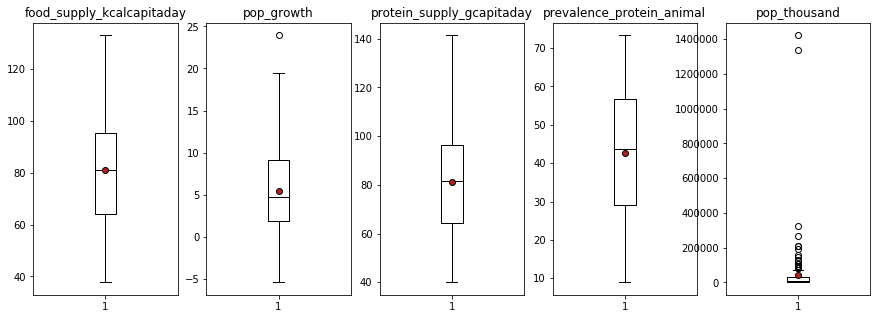

In [34]:
X=data_country_simplified.iloc[:,1:-1]

medianprops = {'color':"black"}
meanprops = {'marker':'o', 'markeredgecolor':'black', 'markerfacecolor':'firebrick'}

i, j = 0, 0
fig, ax = plt.subplots(1, 5, figsize = (15,5))
for k in X.columns:
            ax[i].boxplot(x=X[k], showmeans=True, meanprops=meanprops, medianprops=medianprops)
            ax[i].set_title('{}'.format(k))
            i = i +1

<h3>Complete dataset</h3><a id='simplified'></a>

data_country : complete dataset
- data_pca : data_country with only the variable required fo the PCA
    - data_pca_poultry : sub dataset of data_pca with only variables related to Poultry 
    - data_pca_not_poultry : sub dataset of data_pca with variables not related to Poultry

In [35]:
data_country

,country,food_supply_kcalcapitaday,protein_supply_gcapitaday,pop_thousand,pop_growth,gdp_percapita_usd,gdp_growth,political_stability_index,euro_union,prevalence_protein_animal,growth_prev_protein_animal,prod_poultry_tons,import_poultry_tons,food_poultry_tons,growth_import_poultry,growth_prod_poultry,prevalence_imports_poultry,prevalence_prod_poultry
0,Armenia,90.06,97.33,2944.791,1.629045,3078.978564,9.889928,-0.71,Outside EU,45.782390,3152.624919,47000.0,35000.0,11000.0,9.375000,17.500000,318.181818,427.272727
1,Afghanistan,58.26,54.09,36296.113,12.477767,468.297893,-5.206857,-2.78,Outside EU,19.523017,3093.076604,55000.0,29000.0,28000.0,-39.583333,-26.666667,103.571429,196.428571
2,Albania,111.37,119.50,2884.169,-0.675703,3347.701760,7.818559,0.40,Outside EU,55.497908,3076.113231,47000.0,38000.0,13000.0,52.000000,11.904762,292.307692,361.538462
3,Algeria,91.92,92.85,41389.189,8.518733,3264.338962,-7.348644,-0.96,Outside EU,27.679052,3606.422327,264000.0,2000.0,275000.0,-33.333333,-9.278351,0.727273,96.000000
4,Angola,57.27,54.09,29816.766,14.610305,2805.692595,-15.509934,-0.29,Outside EU,30.449251,3649.891485,315000.0,277000.0,42000.0,-19.005848,-15.322581,659.523810,750.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
167,Belgium,99.37,101.35,11419.748,2.382453,32988.016625,0.652140,0.42,EU,57.109028,3603.148194,144000.0,338000.0,463000.0,34.126984,6.666667,73.002160,31.101512
168,Luxembourg,113.64,105.79,591.910,9.095768,81059.319125,3.178482,1.34,EU,63.692220,2844.396325,11000.0,11000.0,0.0,10.000000,0.000000,0.000000,0.000000
169,Serbia,82.21,82.43,8829.628,-1.000975,4580.333116,6.113513,0.10,Outside EU,48.538154,3302.411517,90000.0,12000.0,85000.0,0.000000,-10.891089,14.117647,105.882353
170,Montenegro,111.90,113.12,627.563,0.194462,5609.035115,11.469796,0.01,Outside EU,60.705446,3245.484703,10000.0,8000.0,4000.0,14.285714,0.000000,200.000000,250.000000


In [36]:
data_country.columns

Index(['country', 'food_supply_kcalcapitaday', 'protein_supply_gcapitaday',
       'pop_thousand', 'pop_growth', 'gdp_percapita_usd', 'gdp_growth',
       'political_stability_index', 'euro_union', 'prevalence_protein_animal',
       'growth_prev_protein_animal', 'prod_poultry_tons',
       'import_poultry_tons', 'food_poultry_tons', 'growth_import_poultry',
       'growth_prod_poultry', 'prevalence_imports_poultry',
       'prevalence_prod_poultry'],
      dtype='object')

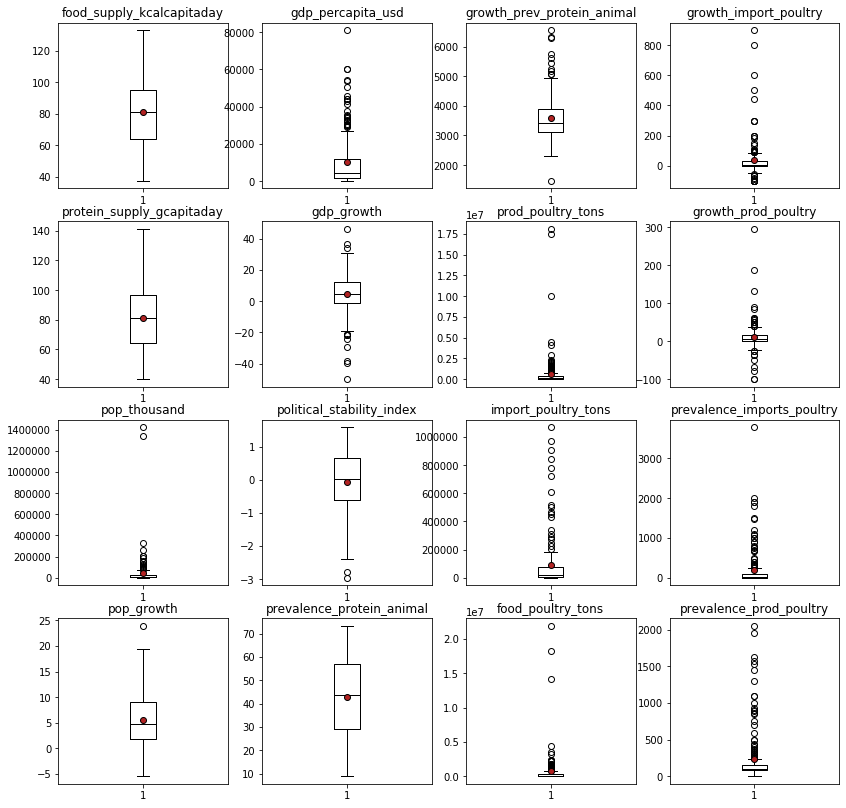

In [37]:
# X includes only quantitative values
X = data_country.drop(['country', 'euro_union'], axis=1)

medianprops = {'color':"black"}
meanprops = {'marker':'o', 'markeredgecolor':'black', 'markerfacecolor':'firebrick'}

fig, ax = plt.subplots(4, 4, figsize = (14,14))
i, j, l, m = 0, 0, 0, 0
for k in X.columns:
        if i < 4:
            ax[i][0].boxplot(x=X[k], showmeans=True, meanprops=meanprops, medianprops=medianprops)
            ax[i][0].set_title('{}'.format(k))
            i = i +1
            
        elif j<4:
            ax[j][1].boxplot(x=X[k], showmeans=True, meanprops=meanprops, medianprops=medianprops)
            ax[j][1].set_title('{}'.format(k))
            j = j+1
        
        elif m<4:
            ax[m][2].boxplot(x=X[k], showmeans=True, meanprops=meanprops, medianprops=medianprops)
            ax[m][2].set_title('{}'.format(k))
            m = m+1
            
        else:
            ax[l][3].boxplot(x=X[k], showmeans=True, meanprops=meanprops, medianprops=medianprops)
            ax[l][3].set_title('{}'.format(k))
            l = l+1

In [38]:
outlier_prod_tons = data_country.loc[data_country['prod_poultry_tons']>15000000]['country'].tolist()
outlier_prev_imports_poultry = data_country.loc[data_country['prevalence_imports_poultry']>3000]['country'].tolist()
outlier_food_poultry = data_country.loc[data_country['food_poultry_tons']>10000000]['country'].tolist()
outlier_growth_import_poultry = data_country.loc[data_country['growth_import_poultry']>400]['country'].tolist()

outlier prod_poultry_tons : {{outlier_prod_tons}}

outlier food_poultry : {{outlier_food_poultry}}

outlier_growth_import_poultry = {{outlier_growth_import_poultry}}

outlier prevalence of imports_poultry " {{outlier_prev_imports_poultry}}
This is not for internal consumption. Hong-Kong is the main route for exportation to China mainland.

In [39]:
# variables to be used on the PCA 
data_pca = data_country[['country', 'food_supply_kcalcapitaday', 'protein_supply_gcapitaday',
        'pop_growth', 'gdp_percapita_usd', 'gdp_growth',
       'political_stability_index', 'prevalence_protein_animal',
       'growth_prev_protein_animal',
       'growth_import_poultry', 'growth_prod_poultry',
       'prevalence_imports_poultry', 'prevalence_prod_poultry']]

In [40]:
data_pca

,country,food_supply_kcalcapitaday,protein_supply_gcapitaday,pop_growth,gdp_percapita_usd,gdp_growth,political_stability_index,prevalence_protein_animal,growth_prev_protein_animal,growth_import_poultry,growth_prod_poultry,prevalence_imports_poultry,prevalence_prod_poultry
0,Armenia,90.06,97.33,1.629045,3078.978564,9.889928,-0.71,45.782390,3152.624919,9.375000,17.500000,318.181818,427.272727
1,Afghanistan,58.26,54.09,12.477767,468.297893,-5.206857,-2.78,19.523017,3093.076604,-39.583333,-26.666667,103.571429,196.428571
2,Albania,111.37,119.50,-0.675703,3347.701760,7.818559,0.40,55.497908,3076.113231,52.000000,11.904762,292.307692,361.538462
3,Algeria,91.92,92.85,8.518733,3264.338962,-7.348644,-0.96,27.679052,3606.422327,-33.333333,-9.278351,0.727273,96.000000
4,Angola,57.27,54.09,14.610305,2805.692595,-15.509934,-0.29,30.449251,3649.891485,-19.005848,-15.322581,659.523810,750.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
167,Belgium,99.37,101.35,2.382453,32988.016625,0.652140,0.42,57.109028,3603.148194,34.126984,6.666667,73.002160,31.101512
168,Luxembourg,113.64,105.79,9.095768,81059.319125,3.178482,1.34,63.692220,2844.396325,10.000000,0.000000,0.000000,0.000000
169,Serbia,82.21,82.43,-1.000975,4580.333116,6.113513,0.10,48.538154,3302.411517,0.000000,-10.891089,14.117647,105.882353
170,Montenegro,111.90,113.12,0.194462,5609.035115,11.469796,0.01,60.705446,3245.484703,14.285714,0.000000,200.000000,250.000000


In [41]:
# subset of data_pca with only data related to Poultry and Chicken 
data_pca_poultry = data_country[['country',
       'growth_import_poultry', 'growth_prod_poultry',
       'prevalence_imports_poultry', 'prevalence_prod_poultry']]

In [42]:
# subset of data_pca with data NOT related to Poultry and Chicken 
data_pca_not_poultry = data_pca.copy()
for i in data_pca.columns: 
    if i in data_pca_poultry.columns and i != 'country':
        data_pca_not_poultry.drop([i], axis = 1, inplace=True)

<hr>

<h2>Exporting Dataset data_country</h2><a id='export'></a>

<h3>Export simplified dataset</h3>

In [43]:
data_country_simplified.to_csv(r'data/output/data_country_simplified.csv', index = False)

<h3>Export complete dataset</h3>

In [44]:
data_country.to_csv(r'data/output/data_country.csv', index = False)

In [45]:
data_pca.to_csv(r'data/output/data_pca.csv', index = False)

In [46]:
data_pca_poultry.to_csv(r'data/output/data_pca_poultry.csv', index = False)

In [47]:
data_pca_not_poultry.to_csv(r'data/output/data_pca_not_poultry.csv', index = False)